Neural Networks


In [9]:
import matplotlib.dates as mdates

In [ ]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance as sklearn_permutation_importance
import matplotlib.dates as mdates



# Create a dictionary to store data for each horizon
test_data = {}
horizons = [1, 5, 21]

# Load test data for each horizon
for horizon in horizons:
    # Define the file path
    file_path = f'C:/Users/maxva/OneDrive - Tilburg University/Msc. Data Science/Master Thesis/Data/merged_results_h{horizon}.csv'
    
    # Load the data and store it in the dictionary
    test_data[horizon] = pd.read_csv(file_path)
    
    # Print confirmation and info about the loaded data
    print(f"Loaded test_data_h{horizon}: {test_data[horizon].shape}")
    print(f"Columns: {test_data[horizon].columns.tolist()[:10]}...")  # First 10 columns
    print("-" * 50)



# Create option-only datasets for each horizon
option_only_data = {}
for horizon in horizons:
    test_data[horizon] = test_data[horizon].copy()
    print(f"\nOption-only data for horizon {horizon}:")
    print(f"Shape: {test_data[horizon].shape}")
    print(test_data[horizon].head())
    print("-" * 50)

train_data = pd.read_csv('C:/Users/maxva/OneDrive - Tilburg University/Msc. Data Science/Master Thesis/Data/merged_results_train.csv')
# Drop the date column
train_data = train_data.drop(columns=['date', 'moneyness_category'])
train_data = train_data
print(f"\nTrain data:")
print(f"Shape: {train_data.shape}")

Loaded test_data_h1: (2571058, 176)
Columns: ['ID', 'iv_cw', 'date', 'cp_flag', 'option_price', 'stock_price', 'moneyness', 'time_to_expiry', 'strike_price', 'volume']...
--------------------------------------------------
Loaded test_data_h5: (2203398, 176)
Columns: ['ID', 'iv_cw', 'date', 'cp_flag', 'option_price', 'stock_price', 'moneyness', 'time_to_expiry', 'strike_price', 'volume']...
--------------------------------------------------
Loaded test_data_h21: (1341910, 176)
Columns: ['ID', 'iv_cw', 'date', 'cp_flag', 'option_price', 'stock_price', 'moneyness', 'time_to_expiry', 'strike_price', 'volume']...
--------------------------------------------------

Option-only data for horizon 1:
Shape: (2571058, 176)
                              ID     iv_cw        date  cp_flag  option_price  \
0  2017-01-03_AAPL 170127C116000  0.264812  2017-01-03        1         2.595   
1  2017-01-03_AAPL 170127C117000  0.266365  2017-01-03        1         2.110   
2  2017-01-03_AAPL 170127C118000  0

In [2]:
###########################################
# PART 1: NEURAL NETWORK MODEL DEFINITION
###########################################

def create_nn_model(architecture_type, input_dim):

    model = Sequential()
    
    # Define architecture based on specifications
    if architecture_type == 'NN3':
        # Three hidden layers with 32, 16, and 8 neurons
        model.add(Dense(128, activation='sigmoid', input_dim=input_dim))
        model.add(Dense(64, activation='sigmoid'))
        model.add(Dense(16, activation='sigmoid'))
        model.add(Dense(1))
    
    elif architecture_type == 'NN4':
        # Four hidden layers with 32, 16, 8, and 4 neurons
        model.add(Dense(128, activation='sigmoid', input_dim=input_dim))
        model.add(Dense(64, activation='sigmoid'))
        model.add(Dense(32, activation='sigmoid'))
        model.add(Dense(16, activation='sigmoid'))
        model.add(Dense(1))
    
    else:
        raise ValueError("Invalid architecture type. Choose from 'NN3' or 'NN4'.")
    
    # Compile model with Adam optimizer for faster training
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
    
    return model

def train_and_evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test, epochs=100):
    # Early stopping with optimized parameters
    callbacks = [
        EarlyStopping(
            monitor='loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='loss',
            factor=0.5,
            patience=5,
            min_lr=1e-5,
            verbose=1
        )
    ]
    
    # Train model with larger batch size for better speed
    history = model.fit(
        X_train_scaled, y_train,
        epochs=epochs,
        batch_size=128,
        validation_split=0.0,
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluate model
    y_pred = model.predict(X_test_scaled, batch_size=128, verbose=0)
    mse = mean_squared_error(y_test, y_pred)
    
    return history, mse


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing    import StandardScaler


def prepare_data(option_only, save_paths=True):
    # 1) Define features & targets
    exclude = [
        'iv_bs_error', 'iv_ahbs', 'iv_ahbs_error', 'iv_bs',
        'iv_cw', 'iv_cw_error', 'impl_volatility', 'ID'
    ]
    features = joblib.load(r'C:\Users\maxva\OneDrive - Tilburg University\Msc. Data Science\Master Thesis\Code\Models\LigthGBM Forecast\Firm Characteristics\feature_columns.pkl')    

    X_train = option_only[features]
    y_train = {
        'bs': option_only['iv_bs_error'],
        'ahbs': option_only['iv_ahbs_error'],
        'cw': option_only['iv_cw_error']
    }

    # 3) Scale training data
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = pd.DataFrame(
        scaler.transform(X_train),
        columns=features
    )

    # 4) Persist artifacts if required
    if save_paths:
        joblib.dump(scaler, 'scaler.pkl')
        joblib.dump(features, 'feature_columns.pkl')

    return X_train_scaled, y_train, scaler, features

In [4]:
def predict_and_add_to_test_data(models, test_data, feature_columns, scaler, error_type):

    # Create a copy of the test data to avoid modifying the original
    result_df = test_data
   
    # Extract features from test data as DataFrame (not as numpy array)
    X_test = test_data[feature_columns]
   
    # Scale the features using the pre-fitted scaler and convert back to DataFrame
    # This preserves feature names and prevents the warning
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test),
        columns=feature_columns,
        index=X_test.index
    )
   
    # Original value column name
    original_column = f'iv_{error_type}'
   
    # Generate predictions for each model
    for model_name, model in models.items():
        # Make predictions
        predictions = model.predict(X_test_scaled, batch_size=128, verbose=0)
       
        # Flatten predictions if needed
        if len(predictions.shape) > 1:
            predictions = predictions.flatten()
       
        # Add predictions to the dataframe
        column_name = f'iv_{error_type}_pred_{model_name}'
        result_df[column_name] = predictions
       
        # Calculate corrected value by adding the error prediction to the original value
        result_df[f'iv_{error_type}_corrected_{model_name}'] = result_df[original_column] + predictions
   
    return result_df

In [ ]:

###########################################
# PART 4: COMPLETE WORKFLOW
###########################################

if __name__ == "__main__":

    # Step 2: Prepare data
    X_train_scaled, y_train, scaler, feature_columns = prepare_data(train_data)
    
    # Step 3: Train models for each target variable
    models = {}
    results = {}
    
    # Dictionary to store all models
    all_models = {
        'bs': {},
        'ahbs': {},
        'cw': {}
    }
    
    # Train models for each error type
    for error_type in ['bs', 'ahbs', 'cw']:
        print(f"\n=== Training models for {error_type} error correction ===")

        # Train each architecture
        for nn_type in ['NN3', 'NN4']:
            model_name = f"{nn_type}_{error_type}"
            print(f"\nTraining {model_name}...")

            # Create model
            model = create_nn_model(nn_type, X_train_scaled.shape[1])

            # Train and evaluate model
            history = train_and_evaluate_model(
                model, X_train_scaled, y_train[error_type], epochs=100
            )

            # Store model and results
            all_models[error_type][nn_type] = model
            results[model_name] = {
                'history': history
            }

            # Save model
            save_model(model, f"{model_name}_model_forecast.h5")




=== Training models for bs error correction ===

Training NN3_bs...


C:\Users\maxva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 14s 769us/step - loss: 0.0027 - learning_rate: 0.0100
Epoch 2/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 13s 773us/step - loss: 0.0010 - learning_rate: 0.0100
Epoch 3/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 13s 794us/step - loss: 9.4150e-04 - learning_rate: 0.0100
Epoch 4/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 13s 770us/step - loss: 9.0280e-04 - learning_rate: 0.0100
Epoch 5/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 13s 774us/step - loss: 8.7318e-04 - learning_rate: 0.0100
Epoch 6/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 13s 773us/step - loss: 8.3908e-04 - learning_rate: 0.0100
Epoch 7/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 13s 801us/step - loss: 8.1906e-04 - learning_rate: 0.0100
Epoch 8/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 13s 747us/step - loss: 8.0558e-04 - learning_rate: 0.0100
Epoch 9/50
16678/16686 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 7.9963e-04
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 13s 752

NN3_bs Test MSE: 0.0003963788125008712

Training NN4_bs...


C:\Users\maxva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 14s 817us/step - loss: 0.0026 - learning_rate: 0.0100
Epoch 2/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 14s 828us/step - loss: 0.0010 - learning_rate: 0.0100
Epoch 3/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 14s 827us/step - loss: 9.5052e-04 - learning_rate: 0.0100
Epoch 4/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 14s 821us/step - loss: 8.9690e-04 - learning_rate: 0.0100
Epoch 5/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 14s 832us/step - loss: 8.8671e-04 - learning_rate: 0.0100
Epoch 6/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 14s 816us/step - loss: 8.5212e-04 - learning_rate: 0.0100
Epoch 7/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 14s 819us/step - loss: 8.4345e-04 - learning_rate: 0.0100
Epoch 8/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 13s 800us/step - loss: 8.1834e-04 - learning_rate: 0.0100
Epoch 9/50
16664/16686 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - loss: 8.1161e-04
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 14s 807

NN4_bs Test MSE: 0.00040919232438068947

=== Training models for ahbs error correction ===

Training NN3_ahbs...


C:\Users\maxva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 13s 735us/step - loss: 0.0024 - learning_rate: 0.0100
Epoch 2/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 729us/step - loss: 0.0010 - learning_rate: 0.0100
Epoch 3/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 738us/step - loss: 9.2296e-04 - learning_rate: 0.0100
Epoch 4/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 728us/step - loss: 9.0230e-04 - learning_rate: 0.0100
Epoch 5/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 733us/step - loss: 8.6539e-04 - learning_rate: 0.0100
Epoch 6/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 731us/step - loss: 8.5990e-04 - learning_rate: 0.0100
Epoch 7/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 726us/step - loss: 8.5535e-04 - learning_rate: 0.0100
Epoch 8/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 731us/step - loss: 8.3378e-04 - learning_rate: 0.0100
Epoch 9/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 12s 732us/step - loss: 8.2051e-04 - learning_rate: 0.0100
Epoch 10/50
16663/16686 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 8.1858e-04
Epoch 10: Re

NN3_ahbs Test MSE: 0.00044536452411562976

Training NN4_ahbs...


C:\Users\maxva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 14s 770us/step - loss: 0.0035 - learning_rate: 0.0100
Epoch 2/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 13s 777us/step - loss: 0.0010 - learning_rate: 0.0100
Epoch 3/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 13s 769us/step - loss: 9.4990e-04 - learning_rate: 0.0100
Epoch 4/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 13s 774us/step - loss: 9.1521e-04 - learning_rate: 0.0100
Epoch 5/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 13s 777us/step - loss: 8.7676e-04 - learning_rate: 0.0100
Epoch 6/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 13s 779us/step - loss: 8.5132e-04 - learning_rate: 0.0100
Epoch 7/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 13s 768us/step - loss: 8.3809e-04 - learning_rate: 0.0100
Epoch 8/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 13s 779us/step - loss: 8.2476e-04 - learning_rate: 0.0100
Epoch 9/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 13s 770us/step - loss: 8.1408e-04 - learning_rate: 0.0100
Epoch 10/50
16654/16686 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - loss: 8.0794e-04
Epoch 10: Re

NN4_ahbs Test MSE: 0.0004559696123782911

=== Training models for cw error correction ===

Training NN3_cw...


C:\Users\maxva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 14s 791us/step - loss: 0.0017 - learning_rate: 0.0100
Epoch 2/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 13s 791us/step - loss: 9.0532e-04 - learning_rate: 0.0100
Epoch 3/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 13s 791us/step - loss: 8.3850e-04 - learning_rate: 0.0100
Epoch 4/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 13s 764us/step - loss: 8.0183e-04 - learning_rate: 0.0100
Epoch 5/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 13s 767us/step - loss: 7.9543e-04 - learning_rate: 0.0100
Epoch 6/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 13s 781us/step - loss: 7.6372e-04 - learning_rate: 0.0100
Epoch 7/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 13s 782us/step - loss: 7.4990e-04 - learning_rate: 0.0100
Epoch 8/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 13s 778us/step - loss: 7.4120e-04 - learning_rate: 0.0100
Epoch 9/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 13s 782us/step - loss: 7.2362e-04 - learning_rate: 0.0100
Epoch 10/50
16628/16686 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - loss: 7.1396e-04
Epoch 10

NN3_cw Test MSE: 0.0004091520450459662

Training NN4_cw...


C:\Users\maxva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 15s 830us/step - loss: 0.0018 - learning_rate: 0.0100
Epoch 2/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 14s 841us/step - loss: 9.1130e-04 - learning_rate: 0.0100
Epoch 3/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 14s 837us/step - loss: 8.7478e-04 - learning_rate: 0.0100
Epoch 4/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 14s 834us/step - loss: 8.1453e-04 - learning_rate: 0.0100
Epoch 5/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 14s 832us/step - loss: 7.9200e-04 - learning_rate: 0.0100
Epoch 6/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 14s 831us/step - loss: 7.6072e-04 - learning_rate: 0.0100
Epoch 7/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 14s 832us/step - loss: 7.5602e-04 - learning_rate: 0.0100
Epoch 8/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 14s 838us/step - loss: 7.3736e-04 - learning_rate: 0.0100
Epoch 9/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 14s 833us/step - loss: 7.3252e-04 - learning_rate: 0.0100
Epoch 10/50
16686/16686 ━━━━━━━━━━━━━━━━━━━━ 13s 798us/step - loss: 7.2611e-04 - learn

NN4_cw Test MSE: 0.000411210025291508


In [5]:


def load_models(model_paths_dict):

    loaded_models = {}
    
    for error_type in model_paths_dict:
        loaded_models[error_type] = {}
        
        for model_name, path in model_paths_dict[error_type].items():
            try:
                # Handle Windows paths by using raw strings
                path = path.replace('\\', '/')  # Convert backslashes to forward slashes
                
                # Check if file exists
                if not os.path.exists(path):
                    print(f"✗ {error_type} {model_name}: File not found at {path}")
                    loaded_models[error_type][model_name] = None
                    continue
                
                # Load the model
                print(f"Loading {error_type} {model_name}...")
                model = load_model(path)
                
                # Simple check: can we access layers?
                num_layers = len(model.layers)
                print(f"✓ Model loaded successfully with {num_layers} layers")
                
                # Store loaded model
                loaded_models[error_type][model_name] = model
                
            except Exception as e:
                print(f"✗ Failed to load {error_type} {model_name}: {str(e)}")
                loaded_models[error_type][model_name] = None
    
    return loaded_models

# Example usage
if __name__ == "__main__":
    # Model paths dictionary with proper path handling for Windows
    # Use forward slashes or raw strings to avoid Unicode escape errors
    model_paths_dict = {
        'bs': {
            'NN3': r"C:/Users/maxva/OneDrive - Tilburg University/Msc. Data Science/Master Thesis/Code/Models/Neural Network forecast/Firm_characteristics/h1/NN3_bs_model_forecast.h5",
            'NN4': r"C:/Users/maxva/OneDrive - Tilburg University/Msc. Data Science/Master Thesis/Code/Models/Neural Network forecast/Firm_characteristics/h1/NN4_bs_model_forecast.h5"
        },
        'ahbs': {
            'NN3': r"C:/Users/maxva/OneDrive - Tilburg University/Msc. Data Science/Master Thesis/Code/Models/Neural Network forecast/Firm_characteristics/h1/NN3_ahbs_model_forecast.h5",
            'NN4': r"C:/Users/maxva/OneDrive - Tilburg University/Msc. Data Science/Master Thesis/Code/Models/Neural Network forecast/Firm_characteristics/h1/NN4_ahbs_model_forecast.h5"
        },
        'cw': {
            'NN3': r"C:/Users/maxva/OneDrive - Tilburg University/Msc. Data Science/Master Thesis/Code/Models/Neural Network forecast/Firm_characteristics/h1/NN3_cw_model_forecast.h5",
            'NN4': r"C:/Users/maxva/OneDrive - Tilburg University/Msc. Data Science/Master Thesis/Code/Models/Neural Network forecast/Firm_characteristics/h1/NN4_cw_model_forecast.h5"
        }
    }
    
    # Load all models
    loaded_models = load_models(model_paths_dict)
    
    # Print summary of loaded models
    print("\n=== Model Loading Summary ===")
    for error_type in loaded_models:
        for model_name in loaded_models[error_type]:
            status = "✓ Loaded" if loaded_models[error_type][model_name] is not None else "✗ Failed"
            print(f"{error_type} {model_name}: {status}")

Loading bs NN3...


✓ Model loaded successfully with 4 layers
Loading bs NN4...
✓ Model loaded successfully with 5 layers
Loading ahbs NN3...
✓ Model loaded successfully with 4 layers
Loading ahbs NN4...
✓ Model loaded successfully with 5 layers
Loading cw NN3...
✓ Model loaded successfully with 4 layers
Loading cw NN4...
✓ Model loaded successfully with 5 layers

=== Model Loading Summary ===
bs NN3: ✓ Loaded
bs NN4: ✓ Loaded
ahbs NN3: ✓ Loaded
ahbs NN4: ✓ Loaded
cw NN3: ✓ Loaded
cw NN4: ✓ Loaded


In [6]:

scaler_path = r"C:\Users\maxva\OneDrive - Tilburg University\Msc. Data Science\Master Thesis\Code\Models\Neural Network forecast\Firm_characteristics\h1\scaler.pkl"
scaler = joblib.load(scaler_path)

for horizon in horizons:
    # 1) load and copy base test set
    print(f"\n=== Horizon {horizon} ===")
    base_df = test_data[horizon]
    
    # 2) determine your features once
    exclude_cols = [
        'iv_bs_error','iv_ahbs','iv_ahbs_error','iv_bs','iv_cw','iv_cw_error',
        'impl_volatility','moneyness_category','ID','date','new_id',
        'open_interest','option_price','prediction_horizon',
        'test_date','train_date','volume'
    ]
    feature_columns = [c for c in base_df.columns if c not in exclude_cols]
    
    # 3) loop over error types _and_ models, but update the SAME DataFrame
    df = base_df
    for error_type in ['bs','ahbs','cw']:
        print(f"\n-- predicting corrections for {error_type} --")
        
        models_for_type = loaded_models[error_type]  # e.g. [nn3_model, nn4_model]
        
        # assume your helper loops through each model internally,
        # adding both iv_{error_type}_pred_NN3/_NN4 and iv_{error_type}_corrected_NN3/_NN4
        df = predict_and_add_to_test_data(
            models_for_type, df, feature_columns, scaler, error_type
        )
        
        # show a quick peek
        cols = ['impl_volatility', f'iv_{error_type}']
        for m in ['NN3','NN4']:
            cols += [f'iv_{error_type}_pred_{m}', f'iv_{error_type}_corrected_{m}']
        print(df[cols].head(3))
    
    # 4) after all error types, assign once
    test_data[horizon] = df
    print(f"\n-- test_data_h{horizon} updated --")


=== Horizon 1 ===

-- predicting corrections for bs --
   impl_volatility     iv_bs  iv_bs_pred_NN3  iv_bs_corrected_NN3  \
0         0.201081  0.288808       -0.071727             0.217081   
1         0.196421  0.288808       -0.068981             0.219827   
2         0.191262  0.288808       -0.067503             0.221304   

   iv_bs_pred_NN4  iv_bs_corrected_NN4  
0       -0.066435             0.222373  
1       -0.068248             0.220559  
2       -0.069829             0.218979  

-- predicting corrections for ahbs --
   impl_volatility   iv_ahbs  iv_ahbs_pred_NN3  iv_ahbs_corrected_NN3  \
0         0.201081  0.299345         -0.060010               0.239336   
1         0.196421  0.298947         -0.053910               0.245037   
2         0.191262  0.298851         -0.053335               0.245516   

   iv_ahbs_pred_NN4  iv_ahbs_corrected_NN4  
0         -0.060623               0.238722  
1         -0.060746               0.238201  
2         -0.063248               0.

C:\Users\maxva\AppData\Local\Temp\ipykernel_22856\1982854859.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subsample = test_df.groupby("date").apply(lambda x: x.sample(frac=0.1, random_state=400)).reset_index(drop=True)


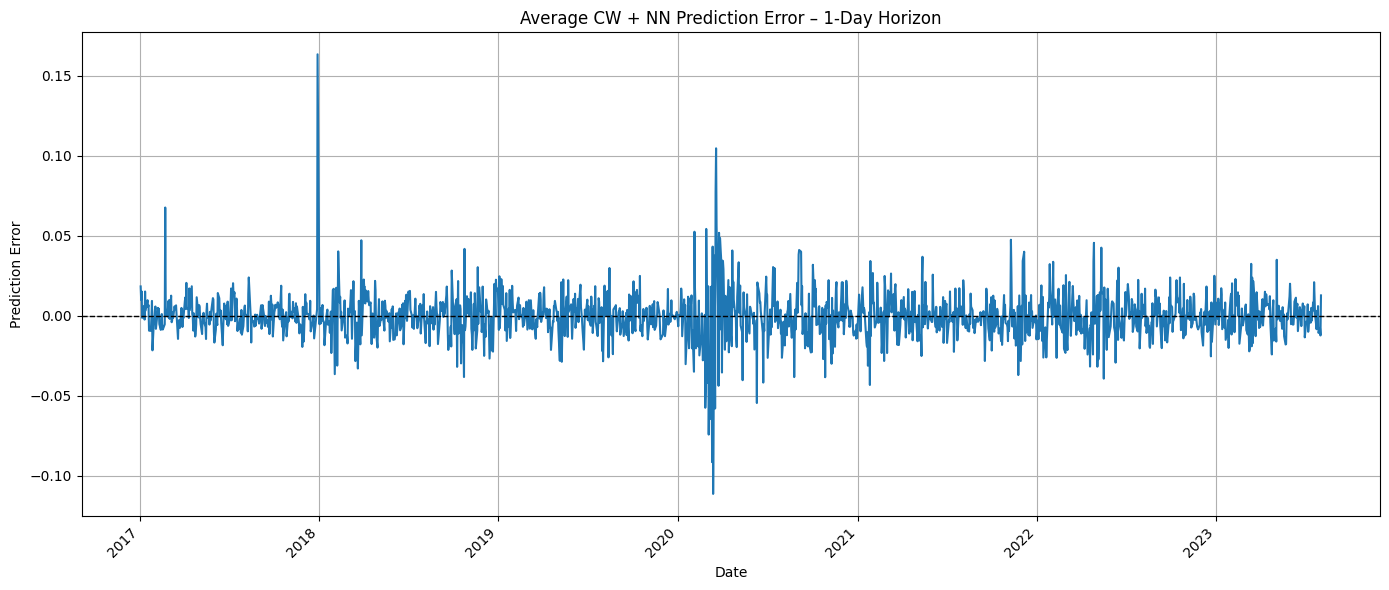

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def compute_and_plot_cw_error(test_df, horizon_label):
    # Subsample 10% per date (increase from 1% for more smoothing)
    subsample = test_df.groupby("date").apply(lambda x: x.sample(frac=0.1, random_state=400)).reset_index(drop=True)

    # Compute CW prediction error
    subsample["error_cw_NN3"] = subsample["iv_cw_corrected_NN3"] - subsample["impl_volatility"]

    # Compute daily average error
    daily_avg_errors = subsample.groupby("date")["error_cw_NN3"].mean().reset_index()

    # Ensure date is datetime type
    daily_avg_errors["date"] = pd.to_datetime(daily_avg_errors["date"])

    # Plot
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(daily_avg_errors["date"], daily_avg_errors["error_cw_NN3"], label="Avg Prediction Error")

    # Formatting
    ax.axhline(0, color="black", linestyle="--", linewidth=1)
    ax.set_title(f"Average CW + NN Prediction Error – {horizon_label} Horizon")
    ax.set_xlabel("Date")
    ax.set_ylabel("Prediction Error")
    ax.grid(True)

    # Format x-axis dates
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

# Example use
compute_and_plot_cw_error(test_data[1], "1-Day")


In [19]:
test_df = test_data[1].copy()
test_df["date"] = pd.to_datetime(test_df["date"])
suspicious_period = test_df[(test_df["date"] >= "2017-12-15") & (test_df["date"] <= "2018-01-10")]

suspicious_period["error"] = suspicious_period["iv_cw_corrected_NN3"] - suspicious_period["impl_volatility"]
suspicious_period.sort_values("error", ascending=False).head(5)


C:\Users\maxva\AppData\Local\Temp\ipykernel_22856\3980881371.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suspicious_period["error"] = suspicious_period["iv_cw_corrected_NN3"] - suspicious_period["impl_volatility"]


,ID,iv_cw,date,cp_flag,option_price,stock_price,moneyness,time_to_expiry,strike_price,volume,...,iv_bs_corrected_NN4,iv_ahbs_pred_NN3,iv_ahbs_corrected_NN3,iv_ahbs_pred_NN4,iv_ahbs_corrected_NN4,iv_cw_pred_NN3,iv_cw_corrected_NN3,iv_cw_pred_NN4,iv_cw_corrected_NN4,error
252115,2017-12-29_NKE 180216P62500,0.423768,2017-12-29,0,1.630,62.960,1.007360,48,62.5,246,...,0.204916,-0.029539,0.205135,-0.027146,0.207528,-0.008151,0.415617,0.001767,0.425535,0.223703
252112,2017-12-29_NKE 180216C65000,0.423768,2017-12-29,1,0.845,62.960,0.968615,48,65.0,321,...,0.212876,-0.027500,0.209334,-0.043047,0.193787,-0.017684,0.406084,0.001399,0.425167,0.221699
252012,2017-12-29_CVS 180216C75000,0.423768,2017-12-29,1,1.510,72.770,0.970267,48,75.0,1555,...,0.258580,0.027156,0.263773,0.011439,0.248057,0.043951,0.467719,0.032364,0.456132,0.219584
251982,2017-12-29_BAC 180216C30000,0.423768,2017-12-29,1,0.780,29.700,0.990000,48,30.0,1708,...,0.224811,-0.004276,0.230613,0.002265,0.237154,0.009910,0.433678,0.001660,0.425428,0.217987
252157,2017-12-29_USB 180209C56000,0.430521,2017-12-29,1,0.400,53.865,0.961875,41,56.0,162,...,0.181109,-0.063483,0.172493,-0.063577,0.172398,-0.054215,0.376306,-0.064417,0.366103,0.216757


In [ ]:
def calculate_ivrmse(predictions_df, error_types=['bs', 'ahbs', 'cw'], models=['NN3', 'NN4']):
    results = {}
    
    # Calculate IVRMSE for each error type and model
    for error_type in error_types:
        orig_col = f'iv_{error_type}'
        
        # Calculate base IVRMSE (before correction)
        base_rmse = np.sqrt(mean_squared_error(predictions_df['impl_volatility'], predictions_df[orig_col]))
        results[f"{error_type}_base"] = base_rmse
        
        # Calculate IVRMSE for each model
        for model in models:
            corrected_col = f'iv_{error_type}_corrected_{model}'
            
            # Skip if corrected column doesn't exist
            if corrected_col not in predictions_df.columns:
                print(f"Warning: {corrected_col} column not found, skipping...")
                continue
                
            # Calculate IVRMSE for the corrected predictions
            corrected_diff = predictions_df['impl_volatility'] - predictions_df[corrected_col]
            corrected_rmse = np.sqrt(mean_squared_error(predictions_df['impl_volatility'], predictions_df[corrected_col]))
            results[f"{error_type}_{model}"] = corrected_rmse
            
            # Calculate improvement percentage
            improvement = (base_rmse - corrected_rmse) / base_rmse * 100
            results[f"{error_type}_{model}_improvement"] = improvement
    
    return results

import pandas as pd

def build_vertical_ivrmse_table(horizons, test_data):
    all_panels = []

    for horizon in horizons:
        ivrmse_results = calculate_ivrmse(test_data[horizon])
        records = []
        for error_type in ['bs', 'ahbs', 'cw']:
            row = []
            base_key = f"{error_type}_base"
            row.append(ivrmse_results.get(base_key, None))
            for model in ['NN3', 'NN4']:
                model_key = f"{error_type}_{model}"
                row.append(ivrmse_results.get(model_key, None))
            records.append(row)

        df = pd.DataFrame(records, 
                          index=['BS', 'AHBS', 'CW'], 
                          columns=['Base', 'NN3', 'NN4'])
        df['Horizon'] = horizon
        all_panels.append(df.reset_index())

    combined_df = pd.concat(all_panels)
    combined_df.rename(columns={'index': 'Error_Type'}, inplace=True)

    # Save to CSV
    output_path = "ivrmse_nm_nn_f_f.csv"
    combined_df.to_csv(output_path, index=False)
    print(f"Saved combined results to {output_path}")

    return combined_df

# Generate and save
combined_csv_df = build_vertical_ivrmse_table(horizons, test_data)


Saved combined results to ivrmse_nm_nn_f_f.csv


Calculate IVRMSE

In [8]:
def add_moneyness_categories(df):
    # Create a copy to avoid modifying the original dataframe
    result = df
    
    # Initialize moneyness_category column with NaN values
    result['moneyness_category'] = np.nan
    
    # Define conditions for each category
    dotmc_mask = (result['cp_flag'] == 1) & (result['moneyness'] >= 0.80) & (result['moneyness'] < 0.90)
    otmc_mask = (result['cp_flag'] == 1) & (result['moneyness'] >= 0.90) & (result['moneyness'] < 0.97)
    atm_mask = (result['moneyness'] >= 0.97) & (result['moneyness'] < 1.03)
    otmp_mask = (result['cp_flag'] == 0) & (result['moneyness'] >= 1.03) & (result['moneyness'] < 1.10)
    dotmp_mask = (result['cp_flag'] == 0) & (result['moneyness'] >= 1.10) & (result['moneyness'] <= 1.60)
    
    # Assign categories based on conditions
    result.loc[dotmc_mask, 'moneyness_category'] = 'DOTMC'
    result.loc[otmc_mask, 'moneyness_category'] = 'OTMC'
    result.loc[atm_mask, 'moneyness_category'] = 'ATM'
    result.loc[otmp_mask, 'moneyness_category'] = 'OTMP'
    result.loc[dotmp_mask, 'moneyness_category'] = 'DOTMP'
    
    return result

for horizon in [1, 5, 21]:
    # Apply moneyness categorization
    test_data[horizon] = add_moneyness_categories(test_data[horizon])
    print(f"Added moneyness categories to test_data_per_horizon[{horizon}]")
        
     # Print sample data to verify
    display_columns = ['cp_flag', 'moneyness', 'moneyness_category']
    print(f"\nSample data for horizon {horizon}:")
    print(test_data[horizon][display_columns].head(5))

Added moneyness categories to test_data_per_horizon[1]

Sample data for horizon 1:
   cp_flag  moneyness moneyness_category
0        1   0.996078                ATM
1        1   0.987564                ATM
2        1   0.979195                ATM
3        1   0.970966                ATM
4        1   0.962875               OTMC


C:\Users\maxva\AppData\Local\Temp\ipykernel_29380\3688721833.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'DOTMC' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  result.loc[dotmc_mask, 'moneyness_category'] = 'DOTMC'
C:\Users\maxva\AppData\Local\Temp\ipykernel_29380\3688721833.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'DOTMC' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  result.loc[dotmc_mask, 'moneyness_category'] = 'DOTMC'


Added moneyness categories to test_data_per_horizon[5]

Sample data for horizon 5:
   cp_flag  moneyness moneyness_category
0        1   0.996078                ATM
1        1   0.987564                ATM
2        1   0.979195                ATM
3        1   0.970966                ATM
4        1   0.962875               OTMC
Added moneyness categories to test_data_per_horizon[21]

Sample data for horizon 21:
   cp_flag  moneyness moneyness_category
0        1   0.962875               OTMC
1        1   0.924360               OTMC
2        1   0.888808              DOTMC
3        1   0.855889              DOTMC
4        0   1.155450              DOTMP


C:\Users\maxva\AppData\Local\Temp\ipykernel_29380\3688721833.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'DOTMC' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  result.loc[dotmc_mask, 'moneyness_category'] = 'DOTMC'


ivrmse per moneyness group

In [ ]:
moneyness_groups = ['DOTMC', 'OTMC', 'ATM', 'OTMP', 'DOTMP']

def analyze_ivrmse_by_moneyness(test_data):

    # 1. Group the test data by moneyness
    results = {}
    for group in moneyness_groups:
        group_data = test_data[test_data['moneyness_category'] == group]
        
        # Skip if no data in this group
        if len(group_data) == 0:
            print(f"Warning: No data found for moneyness group {group}")
            continue
            
        # Initialize results for this group
        results[group] = {}
        
        # 2. Calculate IVRMSE for each error type and model
        for error_type in ['bs', 'ahbs', 'cw']:
            # Column names
            orig_col = f'iv_{error_type}'
            
            # Skip if column doesn't exist
            if orig_col not in group_data.columns:
                print(f"Warning: Column {orig_col} not found, skipping...")
                continue
                
            # Calculate baseline IVRMSE
            base_rmse = np.sqrt(mean_squared_error(
                group_data['impl_volatility'], 
                group_data[orig_col]
            ))
            
            # Store baseline IVRMSE
            results[group][f"{error_type}_base"] = base_rmse
            
            # Calculate corrected IVRMSE for each model
            for model in ['NN3', 'NN4']:
                corrected_col = f'iv_{error_type}_corrected_{model}'
                
                # Skip if column doesn't exist
                if corrected_col not in group_data.columns:
                    print(f"Warning: Column {corrected_col} not found, skipping...")
                    continue
                    
                corrected_rmse = np.sqrt(mean_squared_error(
                    group_data['impl_volatility'], 
                    group_data[corrected_col]
                ))
                
                # Calculate improvement percentage
                improvement = (base_rmse - corrected_rmse) / base_rmse * 100
                
                # Store results
                results[group][f"{error_type}_{model}"] = corrected_rmse
                results[group][f"{error_type}_{model}_improvement"] = improvement
    
    return results

def format_results_table(results):
    # Prepare IVRMSE table data
    ivrmse_data = []
    for group, group_results in results.items():
        row = {'Moneyness Group': group}
        
        for key, value in group_results.items():
            if not key.endswith('improvement'):
                if key.endswith('base'):
                    # Format baseline columns
                    error_type = key.split('_')[0].upper()
                    row[f"{error_type} Base"] = value
                else:
                    # Format model columns
                    parts = key.split('_')
                    error_type = parts[0].upper()
                    model = parts[1]
                    row[f"{error_type} {model}"] = value
        
        ivrmse_data.append(row)
    
    # Prepare improvement percentage table data
    improvement_data = []
    for group, group_results in results.items():
        row = {'Moneyness Group': group}
        
        for key, value in group_results.items():
            if key.endswith('improvement'):
                # Format improvement columns
                parts = key.replace('_improvement', '').split('_')
                error_type = parts[0].upper()
                model = parts[1]
                row[f"{error_type} {model}"] = value
        
        improvement_data.append(row)
    
    # Create DataFrames
    ivrmse_df = pd.DataFrame(ivrmse_data)
    improvement_df = pd.DataFrame(improvement_data)
    
    # Sort columns for better readability
    ivrmse_cols = ['Moneyness Group']
    improvement_cols = ['Moneyness Group']
    
    for et in ['BS', 'AHBS', 'CW']:
        ivrmse_cols.extend([f"{et} Base", f"{et} NN3", f"{et} NN4"])
        improvement_cols.extend([f"{et} NN3", f"{et} NN4"])
    
    # Reorder columns if they exist
    ivrmse_df = ivrmse_df[[col for col in ivrmse_cols if col in ivrmse_df.columns]]
    improvement_df = improvement_df[[col for col in improvement_cols if col in improvement_df.columns]]
    
    return ivrmse_df, improvement_df

def find_best_models(results):
    best_models = []
    
    for group, group_results in results.items():
        for error_type in ['bs', 'ahbs', 'cw']:
            # Get baseline IVRMSE
            base_key = f"{error_type}_base"
            if base_key not in group_results:
                continue
                
            base_rmse = group_results[base_key]
            
            # Find best model for this error type
            models = [m for m in ['NN3', 'NN4'] if f"{error_type}_{m}" in group_results]
            if not models:
                continue
            
            # Find model with lowest IVRMSE    
            best_model = min(models, key=lambda m: group_results[f"{error_type}_{m}"])
            best_rmse = group_results[f"{error_type}_{best_model}"]
            improvement = group_results[f"{error_type}_{best_model}_improvement"]
            
            # Also get the values for the other model for comparison
            other_models = [m for m in models if m != best_model]
            other_model_data = {}
            if other_models:
                other_model = other_models[0]
                other_rmse = group_results[f"{error_type}_{other_model}"]
                other_improvement = group_results[f"{error_type}_{other_model}_improvement"]
                other_model_data = {
                    f'Other Model': other_model,
                    f'Other IVRMSE': other_rmse,
                    f'Other Improvement %': other_improvement
                }
            
            model_data = {
                'Moneyness Group': group,
                'Error Type': error_type.upper(),
                'Best Model': best_model,
                'Base IVRMSE': base_rmse,
                'Best IVRMSE': best_rmse,
                'Improvement %': improvement
            }
            
            # Add other model data if available
            model_data.update(other_model_data)
            
            best_models.append(model_data)
    
    return pd.DataFrame(best_models)

def print_formatted_tables(results):

    # Format results into DataFrames
    ivrmse_df, improvement_df = format_results_table(results)
    
    # Format IVRMSE table
    pd.set_option('display.float_format', '{:.6f}'.format)
    print("=" * 80)
    print(f"IVRMSE by Moneyness Group (Horizon: {horizon})")
    print("=" * 80)
    print(ivrmse_df.to_string(index=False))
    
    # Format improvement table
    pd.set_option('display.float_format', '{:.2f}%'.format)
    print("\n" + "=" * 80)
    print("Improvement Percentage by Moneyness Group")
    print("=" * 80)
    print(improvement_df.to_string(index=False))
    
    # Find best models
    best_models_df = find_best_models(results)
    
    # Reset float format for mixed table
    pd.set_option('display.float_format', None)
    print("\n" + "=" * 80)
    print("Best Model by Moneyness Group and Error Type")
    print("=" * 80)
    # Format specific columns
    best_models_df['Base IVRMSE'] = best_models_df['Base IVRMSE'].map('{:.6f}'.format)
    best_models_df['Best IVRMSE'] = best_models_df['Best IVRMSE'].map('{:.6f}'.format)
    best_models_df['Improvement %'] = best_models_df['Improvement %'].map('{:.2f}%'.format)
    print(best_models_df.to_string(index=False))
    
    # Summary statistics
    print("\n" + "=" * 80)
    print("Summary Statistics")
    print("=" * 80)
    
    # Count best model occurrences
    model_counts = best_models_df['Best Model'].value_counts()
    print(f"Overall best model distribution: {dict(model_counts)}")
    
    # Average improvement by moneyness group
    print("\nAverage improvement by moneyness group:")
    # Convert percentage strings to numeric values
    best_models_df['Improvement_Numeric'] = pd.to_numeric(best_models_df['Improvement %'].str.rstrip('%'))
    
    # Group and calculate means
    avg_improvement = best_models_df.groupby('Moneyness Group')['Improvement_Numeric'].mean()
    
    # Handle the case where there's only one group (which returns a scalar)
    if isinstance(avg_improvement, pd.Series):
        # Sort if it's a Series with multiple values
        sorted_improvements = avg_improvement.sort_values(ascending=False)
        for group, imp in sorted_improvements.items():
            print(f"  {group}: {imp:.2f}%")
    else:
        # Just print the single value if it's a scalar
        group = best_models_df['Moneyness Group'].iloc[0]
        print(f"  {group}: {avg_improvement:.2f}%")

# Example usage:
results_h1 = analyze_ivrmse_by_moneyness(test_data[1])
results_h5 = analyze_ivrmse_by_moneyness(test_data[5])
results_h21 = analyze_ivrmse_by_moneyness(test_data[21])
print(results_h1)

# To get the results as DataFrames for further analysis:
#ivrmse_df, improvement_df = format_results_table(results)
#best_models_df = find_best_models(results)

{'DOTMC': {'bs_base': np.float64(0.12766540322357306), 'bs_NN3': np.float64(0.02990797398289615), 'bs_NN3_improvement': np.float64(76.57315668324014), 'bs_NN4': np.float64(0.030109544621635294), 'bs_NN4_improvement': np.float64(76.41526689191889), 'ahbs_base': np.float64(0.12243075572812812), 'ahbs_NN3': np.float64(0.029705627969835405), 'ahbs_NN3_improvement': np.float64(75.73679277468463), 'ahbs_NN4': np.float64(0.02995692981343165), 'ahbs_NN4_improvement': np.float64(75.53153238720952), 'cw_base': np.float64(0.11351207227281072), 'cw_NN3': np.float64(0.029665086728749367), 'cw_NN3_improvement': np.float64(73.86613940281754), 'cw_NN4': np.float64(0.02973472216861714), 'cw_NN4_improvement': np.float64(73.80479311737538)}, 'OTMC': {'bs_base': np.float64(0.11783968278540764), 'bs_NN3': np.float64(0.02468646867595163), 'bs_NN3_improvement': np.float64(79.05080182462217), 'bs_NN4': np.float64(0.02487454276533491), 'bs_NN4_improvement': np.float64(78.89120016503034), 'ahbs_base': np.float6

In [ ]:
# 1) Change the signature to accept horizon
def print_formatted_tables(results, horizon):

    ivrmse_df, improvement_df = format_results_table(results)
    
    # IVRMSE table
    pd.set_option('display.float_format', '{:.6f}'.format)
    print("=" * 80)
    print(f"IVRMSE by Moneyness Group (Horizon: {horizon})")
    print("=" * 80)
    print(ivrmse_df.to_string(index=False))

    # Improvement %
    pd.set_option('display.float_format', '{:.2f}%'.format)
    print("\n" + "=" * 80)
    print("Improvement Percentage by Moneyness Group")
    print("=" * 80)
    print(improvement_df.to_string(index=False))

    # Best models & summary (same as before)…
    best_models_df = find_best_models(results)
    pd.set_option('display.float_format', None)
    print("\n" + "=" * 80)
    print("Best Model by Moneyness Group and Error Type")
    print("=" * 80)
    best_models_df['Base IVRMSE']    = best_models_df['Base IVRMSE'].map('{:.6f}'.format)
    best_models_df['Best IVRMSE']    = best_models_df['Best IVRMSE'].map('{:.6f}'.format)
    best_models_df['Improvement %']  = best_models_df['Improvement %'].map('{:.2f}%'.format)
    print(best_models_df.to_string(index=False))

    # Summary statistics (same as before)…
    print("\n" + "=" * 80)
    print("Summary Statistics")
    print("=" * 80)
    # (rest of your summary code)

# 2) Now loop over all horizons:
all_results = {
    1: analyze_ivrmse_by_moneyness(test_data[1]),
    5: analyze_ivrmse_by_moneyness(test_data[5]),
    21: analyze_ivrmse_by_moneyness(test_data[21])
}

for h, res in all_results.items():
    print_formatted_tables(res, h)


IVRMSE by Moneyness Group (Horizon: 1)
Moneyness Group  BS Base   BS NN3   BS NN4  AHBS Base  AHBS NN3  AHBS NN4  CW Base   CW NN3   CW NN4
          DOTMC 0.127665 0.029908 0.030110   0.122431  0.029706  0.029957 0.113512 0.029665 0.029735
           OTMC 0.117840 0.024686 0.024875   0.110102  0.024558  0.024719 0.108714 0.024202 0.024199
            ATM 0.115335 0.024095 0.024382   0.110990  0.024319  0.024354 0.108880 0.024134 0.024151
           OTMP 0.108480 0.024692 0.024723   0.106247  0.025044  0.025036 0.105228 0.024728 0.024751
          DOTMP 0.169023 0.031652 0.031762   0.117607  0.034351  0.034488 0.112097 0.034194 0.034269

Improvement Percentage by Moneyness Group
Moneyness Group  BS NN3  BS NN4  AHBS NN3  AHBS NN4  CW NN3  CW NN4
          DOTMC  76.57%  76.42%    75.74%    75.53%  73.87%  73.80%
           OTMC  79.05%  78.89%    77.70%    77.55%  77.74%  77.74%
            ATM  79.11%  78.86%    78.09%    78.06%  77.83%  77.82%
           OTMP  77.24%  77.21%    76.43

In [21]:
import pandas as pd

# get the table
dfm, _ = format_results_table(all_results[1])
dfm5, _ = format_results_table(all_results[5])
dfm21, _ = format_results_table(all_results[21])

# write to CSV (no index column)
dfm.to_csv('results_1_nn_f_f.csv', index=False)
dfm5.to_csv('results_5_nn_f_f.csv', index=False)
dfm21.to_csv('results_21_nn_f_f.csv', index=False)


Feature Importance

In [ ]:
all_models = {
    'bs': {},
    'ahbs': {},
    'cw': {}
}

def analyze_neural_network_weights(model, feature_names, model_name="Neural Network"):

    # Get weights from the first layer
    first_layer_weights = model.layers[0].get_weights()[0]  # Shape: (input_features, neurons)
    
    # Calculate importance as the mean absolute weight for each feature
    importance = np.mean(np.abs(first_layer_weights), axis=1)
    
    # Normalize to sum to 100 for easier interpretation
    importance = 100.0 * (importance / np.sum(importance))
    
    # Create DataFrame with feature names and importance
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    })
    
    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # Print the top features
    print(f"Top 20 most important features for {model_name}:")
    print(importance_df.head(20))
    
    return importance_df

def plot_feature_importance(importance_df, model_name="Neural Network", top_n=30):
    """
    Plot feature importance for the top N features.
    
    Parameters:
    importance_df: DataFrame with feature importance
    model_name: Name of the model for the plot title
    top_n: Number of top features to plot
    """
    # Select top N features
    plot_data = importance_df.head(top_n)
    
    # Create horizontal bar chart
    plt.figure(figsize=(12, 10))
    plt.barh(np.arange(len(plot_data)), plot_data['Importance'], align='center')
    plt.yticks(np.arange(len(plot_data)), plot_data['Feature'])
    plt.xlabel('Relative Importance (%)')
    plt.title(f'Top {top_n} Features - {model_name}')
    plt.tight_layout()
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
    
    return plt.gcf()  # Return the figure for saving if needed

def calculate_permutation_importance(model, X, y, feature_names, n_repeats=10, random_state=42):
    """
    Calculate permutation importance for neural network features.
    Fixed function to avoid naming conflicts.
    
    Parameters:
    model: Trained neural network model
    X: Feature data (numpy array)
    y: Target data
    feature_names: List of feature names
    n_repeats: Number of times to repeat the permutation process
    random_state: Random seed for reproducibility
    
    Returns:
    pd.DataFrame: DataFrame with permutation importance scores
    """
    # Function to predict using the neural network
    def predict_fn(X_data):
        return model.predict(X_data, verbose=0).flatten()
    
    # Calculate permutation importance using the sklearn function
    r = sklearn_permutation_importance(predict_fn, X, y, 
                                      n_repeats=n_repeats,
                                      random_state=random_state)
    
    # Create DataFrame with results
    perm_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': r.importances_mean,
        'Std': r.importances_std
    })
    
    # Sort by importance
    perm_importance_df = perm_importance_df.sort_values('Importance', ascending=False)
    
    return perm_importance_df

def analyze_deeper_layers(model, layer_indices=None):
    """
    Analyze the activation patterns and weights of deeper layers in the network.
    
    Parameters:
    model: Trained neural network model
    layer_indices: List of layer indices to analyze, defaults to all layers
    
    Returns:
    dict: Dictionary with layer analysis information
    """
    if layer_indices is None:
        layer_indices = range(len(model.layers))
    
    layer_info = {}
    
    for i in layer_indices:
        layer = model.layers[i]
        weights = layer.get_weights()
        
        if len(weights) == 0:
            continue
            
        # For each layer, calculate weight statistics
        layer_info[i] = {
            'name': layer.name,
            'type': layer.__class__.__name__,
            'shape': [w.shape for w in weights],
            'weight_stats': {
                'mean': float(np.mean(weights[0])),
                'std': float(np.std(weights[0])),
                'min': float(np.min(weights[0])),
                'max': float(np.max(weights[0])),
                'sparsity': float(np.mean(np.abs(weights[0]) < 1e-10))
            }
        }
        
        if len(weights) > 1:  # Has bias
            layer_info[i]['bias_stats'] = {
                'mean': float(np.mean(weights[1])),
                'std': float(np.std(weights[1])),
                'min': float(np.min(weights[1])),
                'max': float(np.max(weights[1]))
            }
    
    return layer_info

def plot_weight_distributions(model, layer_indices=None):
    """
    Plot the distribution of weights for selected layers.
    
    Parameters:
    model: Trained neural network model
    layer_indices: List of layer indices to analyze, defaults to all layers
    
    Returns:
    None
    """
    if layer_indices is None:
        layer_indices = range(len(model.layers))
    
    # Filter to keep only layers with weights
    layers_with_weights = []
    for i in layer_indices:
        if len(model.layers[i].get_weights()) > 0:
            layers_with_weights.append(i)
    
    if not layers_with_weights:
        print("No layers with weights found.")
        return
    
    n_layers = len(layers_with_weights)
    fig, axes = plt.subplots(n_layers, 1, figsize=(10, 3*n_layers))
    
    if n_layers == 1:
        axes = [axes]
    
    for i, layer_idx in enumerate(layers_with_weights):
        layer = model.layers[layer_idx]
        weights = layer.get_weights()[0]
        
        # Flatten weights for histogram
        flat_weights = weights.flatten()
        
        # Plot histogram
        axes[i].hist(flat_weights, bins=50)
        axes[i].set_title(f"Layer {layer_idx}: {layer.name} - Weight Distribution")
        axes[i].set_xlabel("Weight Value")
        axes[i].set_ylabel("Count")
    
    plt.tight_layout()
    return fig

def analyze_activation_patterns(model, X_sample, layer_indices=None):
    """
    Analyze activation patterns across different layers for a sample of data.
    
    Parameters:
    model: Trained neural network model
    X_sample: Sample input data
    layer_indices: List of layer indices to analyze, defaults to all layers
    
    Returns:
    dict: Dictionary with activation statistics for each layer
    """
    if layer_indices is None:
        layer_indices = range(len(model.layers))
    
    activation_models = {}
    activation_stats = {}
    
    for i in layer_indices:
        try:
            # Create a model that outputs the activations from this layer
            activation_model = tf.keras.Model(
                inputs=model.input,
                outputs=model.layers[i].output
            )
            
            # Get activations
            activations = activation_model.predict(X_sample, verbose=0)
            
            # Calculate activation statistics
            activation_stats[i] = {
                'layer_name': model.layers[i].name,
                'mean': float(np.mean(activations)),
                'std': float(np.std(activations)),
                'min': float(np.min(activations)),
                'max': float(np.max(activations)),
                'sparsity': float(np.mean(activations < 1e-10)),
                'shape': activations.shape
            }
        except:
            # Skip layers that don't support this analysis
            continue
    
    return activation_stats

# Example usage
if __name__ == "__main__":
    # Get your model - either load from file or use the existing model in memory
    # model = load_model("NN3_bs_model.h5")
    try:
        model = all_models['bs']['NN3']
    except KeyError:
        model = loaded_models['bs']['NN3']
    # Get feature names
    feature_names = feature_columns
    
    # 1. Analyze weights and show top features
    importance_df = analyze_neural_network_weights(model, feature_names, "NN3 - BS Error Correction")
    
    # 2. Plot feature importance
    fig = plot_feature_importance(importance_df, "NN3 - BS Error Correction", top_n=30)
    plt.savefig("NN3_bs_feature_importance.png")
    plt.close()
    
    # 3. Analyze deeper layers
    layer_info = analyze_deeper_layers(model)
    print("\n=== Layer Information ===")
    for layer_idx, info in layer_info.items():
        print(f"\nLayer {layer_idx}: {info['name']} ({info['type']})")
        print(f"  Shape: {info['shape']}")
        print(f"  Weight stats: Mean={info['weight_stats']['mean']:.4f}, "
              f"Std={info['weight_stats']['std']:.4f}")
        if 'bias_stats' in info:
            print(f"  Bias stats: Mean={info['bias_stats']['mean']:.4f}, "
                  f"Std={info['bias_stats']['std']:.4f}")
    
    # 4. Plot weight distributions
    weight_fig = plot_weight_distributions(model)
    plt.savefig("NN3_bs_weight_distributions.png")
    plt.close()
    
    # 5. Analyze activations with a small sample
    # (Uncomment if you want to run this analysis)
    # sample_size = min(100, len(X_train_scaled))
    # X_sample = X_train_scaled[:sample_size]
    # activation_stats = analyze_activation_patterns(model, X_sample)
    # print("\n=== Activation Statistics ===")
    # for layer_idx, stats in activation_stats.items():
    #     print(f"\nLayer {layer_idx}: {stats['layer_name']}")
    #     print(f"  Activation: Mean={stats['mean']:.4f}, Std={stats['std']:.4f}")
    #     print(f"  Sparsity: {stats['sparsity']:.2%} (percentage of near-zero activations)")

Top 20 most important features for NN3 - BS Error Correction:
            Feature  Importance
8             theta    2.906260
4      strike_price    1.682651
6             gamma    1.570778
1       stock_price    1.534537
7              vega    1.441805
3    time_to_expiry    1.385853
2         moneyness    1.133738
9                rf    1.052882
0           cp_flag    0.874547
91           pi_nix    0.870244
150      corr_1260d    0.808839
141   turnover_126d    0.806352
151   betabab_1260d    0.765111
103        kz_index    0.763384
83       dsale_dsga    0.752337
105         ni_ivol    0.734855
145        ami_126d    0.731005
153             age    0.730412
44        ncol_gr1a    0.718287
60     oaccruals_ni    0.712396

=== Layer Information ===

Layer 0: dense (Dense)
  Shape: [(159, 128), (128,)]
  Weight stats: Mean=0.0629, Std=3.8003
  Bias stats: Mean=-1.6224, Std=7.3908

Layer 1: dense_1 (Dense)
  Shape: [(128, 64), (64,)]
  Weight stats: Mean=-0.2404, Std=2.0106
  Bias stat

In [ ]:
sample_df = test_data[1].sample(n=1000000, random_state=42)


In [ ]:

def manual_permutation_importance(model, X: np.ndarray, y: np.ndarray,
                                  feature_names: list[str],
                                  n_repeats: int = 10,
                                  random_state: int = 42) -> pd.Series:
    rng = np.random.RandomState(random_state)
    baseline_preds = model.predict(X, verbose=0).flatten()
    baseline_score = mean_squared_error(y, baseline_preds)

    importances = []
    for idx, col in enumerate(feature_names):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X.copy()
            X_permuted[:, idx] = rng.permutation(X_permuted[:, idx])
            permuted_preds = model.predict(X_permuted, verbose=0).flatten()
            score = mean_squared_error(y, permuted_preds)
            scores.append(score - baseline_score)
        importances.append(np.mean(scores))

    return pd.Series(importances, index=feature_names).sort_values(ascending=False)

def plot_importance(importance: pd.Series, top_n: int = 20, title: str = "Feature Importance"):

    data = importance.head(top_n).sort_values()
    plt.figure(figsize=(8, max(4, 0.2 * top_n)))
    data.plot.barh()
    plt.xlabel('Importance (Increase in MSE)')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Prepare data once
X_test_scaled, y_test_dict, _, feature_names = prepare_data(sample_df, save_paths=False)

# Load pre-saved feature columns (if different than current feature_names)
feature_columns = joblib.load(r'C:\Users\maxva\OneDrive - Tilburg University\Msc. Data Science\Master Thesis\Code\Models\LigthGBM Forecast\Firm Characteristics\feature_columns.pkl')

groups = ['bs']
arches = ['NN3']

for grp in groups:
    for arch in arches:
        try:
            model = all_models[grp][arch]
        except KeyError:
            try:
                model = loaded_models[grp][arch]
            except KeyError:
                print(f"⚠️ Model not found for group '{grp}' and architecture '{arch}'. Skipping.")
                continue

        # Select the correct target (y) for this group
        y_test = y_test_dict[grp]

        # Compute permutation importance
        imp_perm = manual_permutation_importance(model, X_test_scaled.values, y_test.values, feature_columns)
        title = f"{grp.upper()} {arch} Combined Dataset"
        plot_importance(imp_perm, top_n=20, title=title)


KeyboardInterrupt: 

In [ ]:
print(model)

<Sequential name=sequential_5, built=True>
